In [1]:
# --- 1. Reikalingos bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import pickle
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [2]:
# --- 2. Duomenų gavimas iš Binance API (jei reikia) arba naudojami jau išsaugoti ---
cached_data_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')

if os.path.exists(cached_data_path):
    print(f"Naudojami cached duomenys iš {cached_data_path}")
    df = pd.read_csv(cached_data_path)
    df['time'] = pd.to_datetime(df['time'])
    print(f"Duomenų dydis: {df.shape}")
    print(df.head())
else:
    print(f"KLAIDA: Nerastas duomenų failas {cached_data_path}")
    print("Pirma paleiskite duomenų gavimo skriptą arba kitą modelio failą, pvz., lstm_model.ipynb")

Naudojami cached duomenys iš ..\..\data\btc_data_1y_15m.csv
Duomenų dydis: (175092, 12)
                 time     open     high      low    close      volume  \
0 2020-05-24 00:00:00  9179.01  9180.84  9120.77  9159.12  848.903974   
1 2020-05-24 00:15:00  9159.78  9182.28  9149.86  9174.77  473.021813   
2 2020-05-24 00:30:00  9174.77  9189.67  9170.00  9188.25  404.924533   
3 2020-05-24 00:45:00  9187.64  9212.00  9186.31  9196.38  458.199259   
4 2020-05-24 01:00:00  9196.38  9208.82  9185.93  9190.30  201.842188   

      close_time  quote_asset_volume  number_of_trades  \
0  1590279299999        7.765461e+06              9619   
1  1590280199999        4.336501e+06              6057   
2  1590281099999        3.717366e+06              5848   
3  1590281999999        4.215554e+06              6889   
4  1590282899999        1.856587e+06              3735   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                   296.252396                  2.709

In [3]:
# --- 3. Duomenų paruošimas ir normalizavimas ---
df = df.sort_values('time')
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Patikriname normalizuotus duomenis
print("Normalizuotų duomenų statistika:")
print(df_normalized[columns_to_normalize].describe())

# Išsaugome scaler'į vėlesniam naudojimui
import pickle
os.makedirs('../../models', exist_ok=True)
with open('../../models/cnn_lstm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Normalizuotų duomenų statistika:
                open           high            low          close  \
count  175092.000000  175092.000000  175092.000000  175092.000000   
mean        0.331695       0.331983       0.331789       0.331698   
std         0.236697       0.237053       0.236653       0.236702   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.142599       0.142462       0.142854       0.142597   
50%         0.287999       0.288537       0.287826       0.287999   
75%         0.490462       0.490955       0.490552       0.490463   
max         1.000000       1.000000       1.000000       1.000000   

              volume  
count  175092.000000  
mean        0.020685  
std         0.031561  
min         0.000000  
25%         0.005429  
50%         0.010370  
75%         0.022283  
max         1.000000  


In [4]:
# --- 4. Sliding window sekų kūrimas ---
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 48  # Hibridiniam modeliui pasirenkame vidutinio ilgio seką
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (175044, 48, 5), y shape: (175044,)


In [5]:
# --- 5. Duomenų padalijimas į mokymo ir testavimo rinkinius ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (140035, 48, 5), X_test shape: (35009, 48, 5)
y_train shape: (140035,), y_test shape: (35009,)


In [6]:
# --- 6. CNN-LSTM hibridinio modelio sukūrimas ---
def create_cnn_lstm_model(input_shape):
    model = models.Sequential([
        # 1D konvoliucijos sluoksnis lokalių šablonų aptikimui
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        # LSTM sluoksniai laiko eilučių priklausomybių modeliavimui
        layers.LSTM(units=100, return_sequences=True),
        layers.Dropout(0.2),
        
        layers.LSTM(units=50),
        layers.Dropout(0.2),
        
        # Tankinimo sluoksniai
        layers.Dense(50, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(1)  # Išvesties sluoksnis (kainų prognozė)
    ])
    return model

# Sukuriame modelį
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
cnn_lstm_model = create_cnn_lstm_model(input_shape)

# Sukompiliuojame modelį
cnn_lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

cnn_lstm_model.summary()

d:\CA_BTC\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,147 (594.32 KB)

 Trainable params: 151,763 (592.82 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# --- 7. Modelio apmokymas ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    filepath='../../models/cnn_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Apmokymo paleidimas
print("Pradedamas modelio apmokymas...")
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Modelio apmokymas baigtas.")

# Išsaugome modelį
cnn_lstm_model.save('../../models/cnn_lstm_model.h5')
print("Modelis išsaugotas į: ../../models/cnn_lstm_model.h5")

Pradedamas modelio apmokymas...
Epoch 1/100
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - mae: 0.0254
Epoch 1: val_loss improved from inf to 0.03477, saving model to ../../models/cnn_lstm_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 91s 19ms/step - loss: 0.0015 - mae: 0.0254 - val_loss: 0.0348 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 2/100
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1356e-04 - mae: 0.0105
Epoch 2: val_loss improved from 0.03477 to 0.03333, saving model to ../../models/cnn_lstm_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - loss: 2.1350e-04 - mae: 0.0105 - val_loss: 0.0333 - val_mae: 0.1433 - learning_rate: 0.0010
Epoch 3/100
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1966e-04 - mae: 0.0080
Epoch 3: val_loss improved from 0.03333 to 0.03193, saving model to ../../models/cnn_lstm_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - loss: 1.1964e-04 - mae: 0.0080 - val_loss: 0.0319 - val_mae: 0.1380 - learning_rate: 0.0010
Epoch 4/100
4376/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.1625e-05 - mae: 0.0059
Epoch 4: val_loss improved from 0.03193 to 0.02906, saving model to ../../models/cnn_lstm_model.h5


4377/4377 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - loss: 6.1623e-05 - mae: 0.0059 - val_loss: 0.0291 - val_mae: 0.1286 - learning_rate: 0.0010
Epoch 5/100
4374/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8672e-05 - mae: 0.0056
Epoch 5: val_loss did not improve from 0.02906
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - loss: 5.8663e-05 - mae: 0.0056 - val_loss: 0.0309 - val_mae: 0.1343 - learning_rate: 0.0010
Epoch 6/100
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3278e-05 - mae: 0.0049
Epoch 6: val_loss did not improve from 0.02906
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 97s 22ms/step - loss: 4.3275e-05 - mae: 0.0049 - val_loss: 0.0316 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 7/100
4375/4377 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.5991e-05 - mae: 0.0044
Epoch 7: val_loss did not improve from 0.02906
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 92s 21ms/step - loss: 3.5991e-05 - mae: 0.0044 - val_loss: 0.0305 - val_mae: 0.1313 - learning_rate: 0.0010
Epoch 8/100
4375/4377 ━━━━━━━━━━━━━━

Modelio apmokymas baigtas.
Modelis išsaugotas į: ../../models/cnn_lstm_model.h5


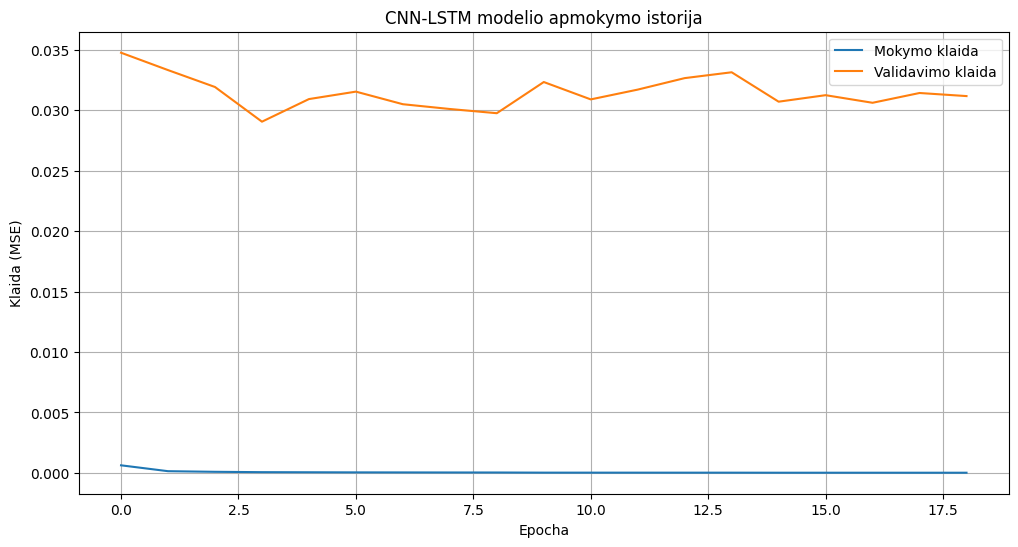

In [8]:
# --- 8. Apmokymo istorijos vizualizacija ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('CNN-LSTM modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

if 'lr' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Kitimas')
    plt.xlabel('Epocha')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

In [9]:
# --- 9. Modelio testavimas ---
y_pred = cnn_lstm_model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx, feature_columns)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


In [10]:
# --- 10. Modelio įvertinimas ---
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Sukuriame DataFrame geresniam pavaizavimui
metrics_df = pd.DataFrame({
    'Metrika': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Reikšmė': [mse, rmse, mae, r2, mape]
})
display(metrics_df)

Mean Squared Error (MSE): 309599698.28
Root Mean Squared Error (RMSE): 17595.45
Mean Absolute Error (MAE): 13270.23
R² Score: -0.1538
Mean Absolute Percentage Error (MAPE): 14.37%


,Metrika,Reikšmė
0,MSE,3.095997e+08
1,RMSE,1.759545e+04
2,MAE,1.327023e+04
3,R²,-1.538192e-01
4,MAPE (%),1.436916e+01


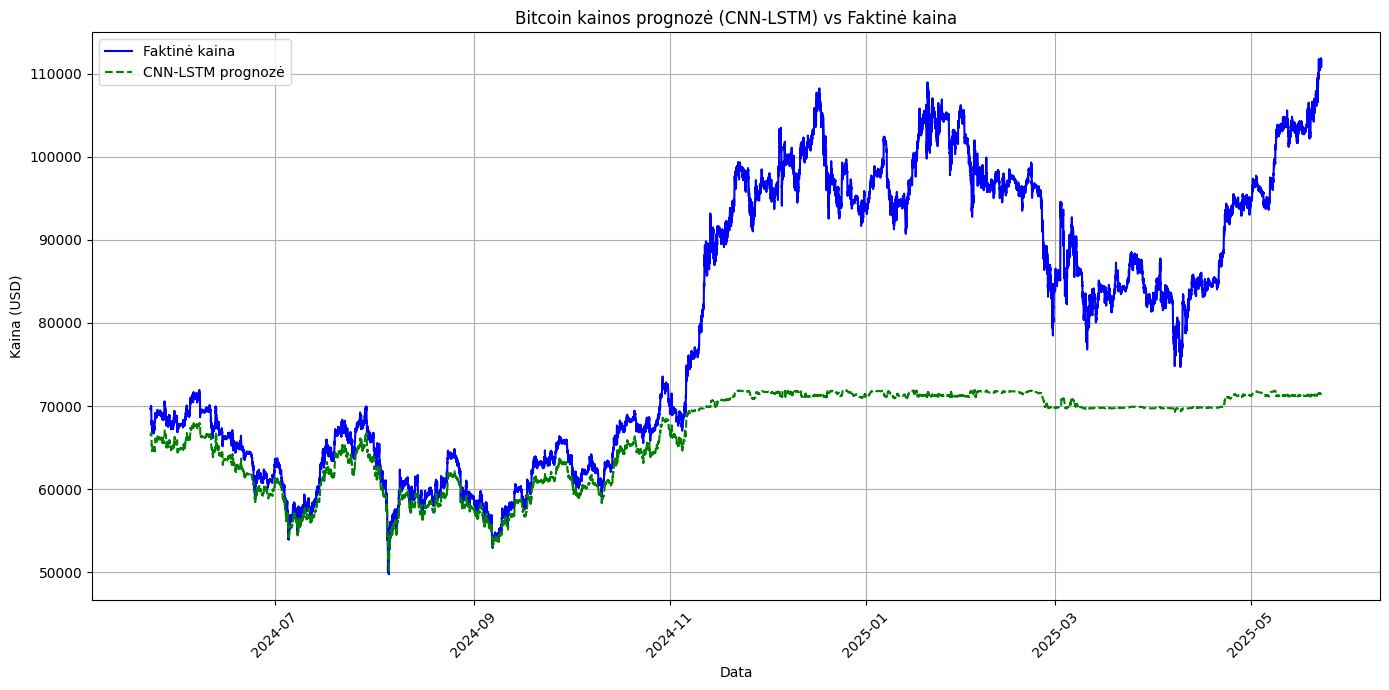

In [11]:
# --- 11. Prognozių vizualizacija ---
# Pasiimame testavimo rinkinių datas
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='CNN-LSTM prognozė', color='green', linestyle='--')
plt.title('Bitcoin kainos prognozė (CNN-LSTM) vs Faktinė kaina')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# --- 12. Modelio informacijos išsaugojimas ---
model_info = {
    'model_type': 'CNN-LSTM',
    'input_shape': [sequence_length, len(feature_columns)],
    'sequence_length': sequence_length,
    'target_column': target_column,
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/cnn_lstm_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")

Modelio informacija išsaugota: ../../models/cnn_lstm_model_info.json
